# Delivery Route Optimization — Solving the Traveling Salesman Problem for Los Angeles

## Project Goal
The goal of this project is to **find the most efficient delivery route** that visits all customer locations exactly once and returns to the depot — a classic **Traveling Salesman Problem (TSP)**.

By optimizing delivery routes, businesses can:
- **Reduce travel distance and fuel costs**
- **Minimize delivery times**
- **Lower CO₂ emissions**
- **Improve customer satisfaction**

## Problem Statement
Last-mile delivery is one of the **most expensive and time-consuming** parts of logistics.  
Given a set of delivery locations in Los Angeles, how can we:
1. Start from the depot
2. Visit each location exactly once
3. Return to the depot
4. Minimize the total travel distance

We will solve this problem using:
- **Haversine distance** (great-circle distance calculation)
- **Nearest Neighbor heuristic**
- **2-opt local search optimization**
- Interactive maps for visualization


In [2]:
# Install required packages if not available
%pip install pandas numpy folium matplotlib geopy --quiet

Note: you may need to restart the kernel to use updated packages.


## 1. Import libraries

In [5]:
import math, random
from pathlib import Path
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt

EARTH_R = 6371.0088  # km

## 2. Generate synthetic Los Angeles delivery data

In [8]:
def haversine_km(lat1, lon1, lat2, lon2):
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlmb/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return EARTH_R * c

def build_distance_matrix(df):
    n = len(df)
    dist = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            d = haversine_km(df.lat[i], df.lon[i], df.lat[j], df.lon[j])
            dist[i, j] = d
            dist[j, i] = d
    return dist

def random_point(lat, lon, radius_km):
    r = radius_km * 1000
    u, v = random.random(), random.random()
    w = r * (u ** 0.5)
    t = 2 * math.pi * v
    dx, dy = w * math.cos(t), w * math.sin(t)
    dlat = dy / 111_320
    dlon = dx / (111_320 * math.cos(math.radians(lat)))
    return lat + dlat, lon + dlon

def generate_data(n=10, seed=42, city="Los Angeles", center=(34.0522, -118.2437), radius_km=10):
    random.seed(seed)
    rows = [(0, f"{city} Depot", center[0], center[1])]
    for i in range(1, n):
        lat, lon = random_point(center[0], center[1], radius_km)
        rows.append((i, f"Stop {i}", lat, lon))
    df = pd.DataFrame(rows, columns=["id","name","lat","lon"])
    return df

# Generate sample dataset
df = generate_data(n=12, seed=1)
df

,id,name,lat,lon
0,0,Los Angeles Depot,34.052200,-118.243700
1,1,Stop 1,34.025252,-118.220861
2,2,Stop 2,34.130667,-118.246717
3,3,Stop 3,34.071931,-118.316205
4,4,Stop 4,33.981823,-118.222615
5,5,Stop 5,34.057076,-118.211009
6,6,Stop 6,34.085869,-118.334107
7,7,Stop 7,34.053238,-118.149046
8,8,Stop 8,33.993205,-118.256570
9,9,Stop 9,34.037715,-118.194878


## 3. Quick EDA — Map and Distance Distribution

In [11]:
# Scatter map of delivery points
m_points = folium.Map(location=[df.lat[0], df.lon[0]], zoom_start=12)
for _, row in df.iterrows():
    folium.Marker([row.lat, row.lon], popup=row.name).add_to(m_points)
m_points

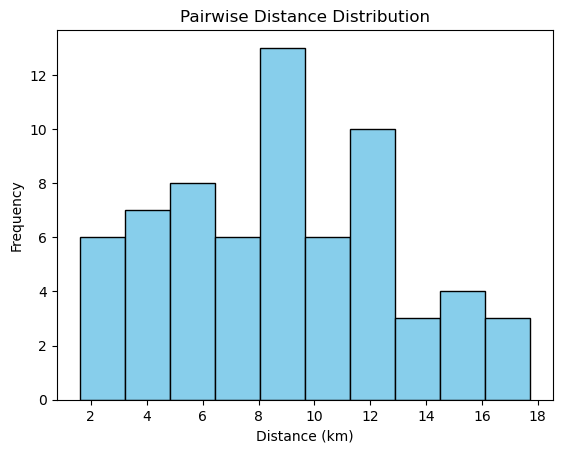

In [13]:
# Histogram of pairwise distances
dist_matrix = build_distance_matrix(df)
dists = dist_matrix[np.triu_indices(len(df), k=1)]
plt.hist(dists, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Pairwise Distance Distribution')
plt.show()

## 4. TSP Solver — Nearest Neighbor + 2-opt

In [16]:
def route_cost(route, dist):
    return sum(dist[route[i], route[i+1]] for i in range(len(route)-1))

def nearest_neighbor(dist, start=0):
    n = len(dist)
    unvisited = set(range(n))
    route = [start]
    unvisited.remove(start)
    cur = start
    while unvisited:
        nxt = min(unvisited, key=lambda j: dist[cur][j])
        route.append(nxt)
        unvisited.remove(nxt)
        cur = nxt
    route.append(start)
    return route

def two_opt(route, dist, max_iters=10000):
    best = route[:]
    best_cost = route_cost(best, dist)
    improved = True
    iters = 0
    while improved and iters < max_iters:
        improved = False
        for i in range(1, len(best)-2):
            for k in range(i+1, len(best)-1):
                if iters >= max_iters: break
                iters += 1
                new_route = best[:i] + best[i:k+1][::-1] + best[k+1:]
                new_cost = route_cost(new_route, dist)
                if new_cost + 1e-9 < best_cost:
                    best, best_cost = new_route, new_cost
                    improved = True
                    break
            if improved:
                break
    return best

## 5. Run TSP Optimization and Visualize Route

In [19]:
# Build distance matrix
dist_km = build_distance_matrix(df)

# Solve with NN + 2-opt
nn_route = nearest_neighbor(dist_km, start=0)
opt_route = two_opt(nn_route, dist_km)
opt_cost = route_cost(opt_route, dist_km)

print("Optimized Route:", opt_route)
print(f"Total Distance: {opt_cost:.2f} km")

# Folium route map
m_route = folium.Map(location=[df.lat[0], df.lon[0]], zoom_start=12)
coords = [(df.lat[i], df.lon[i]) for i in opt_route]
folium.PolyLine(coords, weight=4, opacity=0.8, color='blue').add_to(m_route)
for idx, i in enumerate(opt_route):
    folium.CircleMarker(location=(df.lat[i], df.lon[i]), radius=5,
                        popup=f"Stop {idx}: {df.name[i]}", color='red').add_to(m_route)

from pathlib import Path

# Save and display
Path('out').mkdir(exist_ok=True)
m_route.save('out/tsp_map_LA.html')
m_route


Optimized Route: [0, 11, 3, 6, 2, 10, 7, 9, 4, 8, 1, 5, 0]
Total Distance: 58.91 km


In [21]:
# Results
if 'dist_km' not in locals():
    dist_km = build_distance_matrix(df)

if 'nn_route' not in locals():
    nn_route = nearest_neighbor(dist_km, start=0)

if 'opt_route' not in locals():
    opt_route = two_opt(nn_route, dist_km)

# Costs
nn_cost = route_cost(nn_route, dist_km)
opt_cost = route_cost(opt_route, dist_km)
distance_saved = nn_cost - opt_cost
improvement_pct = (distance_saved / nn_cost) * 100 if nn_cost > 0 else 0.0

# Metrics
avg_speed_kmh = 30.0          # average driving speed used to estimate time
fuel_efficiency_km_per_l = 12 # vehicle fuel efficiency
fuel_price_per_l = 1.25       # local fuel price
co2_per_l_kg = 2.31           # kg CO₂ per liter of gasoline

# Derived metrics
time_nn_hr  = nn_cost  / avg_speed_kmh
time_opt_hr = opt_cost / avg_speed_kmh
fuel_saved_l = max(distance_saved, 0) / fuel_efficiency_km_per_l
cost_saved_usd = fuel_saved_l * fuel_price_per_l
co2_saved_kg = fuel_saved_l * co2_per_l_kg

# Summary
print("=== TSP Results (Los Angeles) ===")
print(f"Stops (including depot): {len(df)}")
print(f"Nearest Neighbor distance: {nn_cost:.2f} km  (~{time_nn_hr:.2f} h @ {avg_speed_kmh:.0f} km/h)")
print(f"Optimized (NN + 2‑opt) distance: {opt_cost:.2f} km  (~{time_opt_hr:.2f} h @ {avg_speed_kmh:.0f} km/h)")
print(f"Improvement over NN: {improvement_pct:.2f}%  ({distance_saved:.2f} km saved)")
print("")
print("Estimated daily impact (per vehicle):")
print(f"Fuel saved: {fuel_saved_l:.2f} L")
print(f"Cost saved: ${cost_saved_usd:.2f}")
print(f"CO₂ reduction: {co2_saved_kg:.2f} kg")

Path("out").mkdir(exist_ok=True)
summary = pd.DataFrame([{
    "stops": len(df),
    "nn_distance_km": nn_cost,
    "opt_distance_km": opt_cost,
    "distance_saved_km": distance_saved,
    "improvement_pct": improvement_pct,
    "time_nn_hr": time_nn_hr,
    "time_opt_hr": time_opt_hr,
    "fuel_saved_l": fuel_saved_l,
    "cost_saved_usd": cost_saved_usd,
    "co2_saved_kg": co2_saved_kg,
    "avg_speed_kmh": avg_speed_kmh,
    "fuel_efficiency_km_per_l": fuel_efficiency_km_per_l,
    "fuel_price_per_l": fuel_price_per_l,
    "co2_per_l_kg": co2_per_l_kg,
}])
summary.to_csv("out/tsp_results_summary.csv", index=False)
print("\nSaved: out/tsp_results_summary.csv")


=== TSP Results (Los Angeles) ===
Stops (including depot): 12
Nearest Neighbor distance: 66.16 km  (~2.21 h @ 30 km/h)
Optimized (NN + 2‑opt) distance: 58.91 km  (~1.96 h @ 30 km/h)
Improvement over NN: 10.96%  (7.25 km saved)

Estimated daily impact (per vehicle):
Fuel saved: 0.60 L
Cost saved: $0.76
CO₂ reduction: 1.40 kg

Saved: out/tsp_results_summary.csv


## Inference and Results

The optimized route was computed using the Nearest Neighbor heuristic followed by 2-opt.

**Key findings**
- Number of stops (including depot): {len(df)}
- Nearest Neighbor distance: {nn_cost:.2f} km
- Optimized distance: {opt_cost:.2f} km
- Improvement over Nearest Neighbor: {improvement_pct:.2f}% ({distance_saved:.2f} km saved)

**Estimated impact (per vehicle, based on assumptions)**
- Fuel saved: {fuel_saved_l:.2f} L per day
- Cost saved: ${cost_saved_usd:.2f} per day
- CO₂ reduction: {co2_saved_kg:.2f} kg per day

Assumptions: average speed = {avg_speed_kmh:.0f} km/h, fuel efficiency = {fuel_efficiency_km_per_l} km/L, fuel price = ${fuel_price_per_l}/L, CO₂ = {co2_per_l_kg} kg/L.
